In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Work/Sciencing/Data/DMPAD_168/

/content/drive/MyDrive/Work/Sciencing/Data/DMPAD_168


In [ ]:
#from Model_pytorch import wwd_model_pytorch_new
import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import seaborn as sns # for plotting 
import time # for timer
import torch
import torch.optim as optim
import scipy.io


from torch.nn.parameter import Parameter
import pickle
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
class OutputJR():
    mode_all = ['train', 'test']
    stat_vars_all = ['m', 'v']
    def __init__(self, state_names, node_size, param, fit_weights=False):
        self.loss = np.array([])
        
        for name in state_names+['EEG']:
           for m in self.mode_all:
               setattr(self, name+'_'+m,np.array([]))
        
        vars = [a for a in dir(param) if not a.startswith('__') and not callable(getattr(param, a))]
        for var in vars:
            if np.any(getattr(param, var)[1]> 0):
                if var != 'std_in':
                    setattr(self, var, np.array([]))
                    for stat_var in self.stat_vars_all:
                        setattr(self, var+'_'+stat_var, np.array([]))
                else:
                    setattr(self, var, np.array([]))
        if  fit_weights == True:
            self.weights = np.array([])
        self.leadfield = np.array([])
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        
class ParamsJR():
    
    def __init__(self, **kwargs):
        for var in kwargs:
            setattr(self, var, kwargs[var])
        

In [ ]:
def sys2nd(A, a,  u, x, v):
    return A*a*u -2*a*v-a**2*x

def sigmoid(x, vmax, v0, r):
    return vmax/(1+torch.exp(r*(v0-x)))


class RNNJANSEN(torch.nn.Module):
    """
    A module for forward model (JansenRit) to simulate a batch of EEG signals
    
    Attibutes
    ---------
    state_size : int
        the number of states in the JansenRit model
    input_size : int
        the number of states with noise as input
    tr : float
        tr of image
    step_size: float
        Integration step for forward model
    hidden_size: int
        the number of step_size in a tr 
    batch_size: int
        the number of EEG signals to simulate
    node_size: int
        the number of ROIs
    sc: float node_size x node_size array   
        structural connectivity
    fit_gains: bool
        flag for fitting gains 1: fit 0: not fit

    g, c1, c2, c3,c4: tensor with gradient on
        model parameters to be fit

    w_bb: tensor with node_size x node_size (grad on depends on fit_gains)
        connection gains

    std_in std_out: tensor with gradient on
        std for state noise and output noise

    hyper parameters for prior distribution of model parameters


    Methods
    -------
    forward(input, noise_out, hx)
        forward model (JansenRit) for generating a number of EEG signals with current model parameters

    """
    state_names = ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']
    def __init__(self, input_size: int, node_size: int,
                 batch_size: int, step_size: float, eeg_size: int, behav_size: int, stimus_size: int, tr: float, sc: float,\
                 dist:float, lm: float, fit_gains: bool, \
                 param: ParamsJR) -> None:
        """
        Parameters
        ----------
        state_size : int
        the number of states in the JansenRit model
        input_size : int
            the number of states with noise as input
        tr : float
            tr of image
        step_size: float
            Integration step for forward model
        hidden_size: int
            the number of step_size in a tr 
        batch_size: int
            the number of EEG signals to simulate
        node_size: int
            the number of ROIs
        output_size: int
            the number of channels EEG
        sc: float node_size x node_size array   
            structural connectivity
        fit_gains: bool
            flag for fitting gains 1: fit 0: not fit
        param from ParamJR

        """
        super(RNNJANSEN, self).__init__()
        self.state_size = 6 # 6 states WWD model
        self.input_size = input_size # 1 or 2 or 3
        self.tr = tr # tr ms (integration step 0.1 ms)
        self.step_size = torch.tensor(step_size , dtype=torch.float32) # integration step 0.1 ms
        self.hidden_size = np.int(tr/step_size)
        self.batch_size = batch_size # size of the batch used at each step
        self.node_size = node_size # num of ROI   
        self.eeg_size = eeg_size # num of EEG channels 
        self.behav_size = behav_size # num of behavior data
        self.stimus_size = stimus_size # num of stimus   
        self.sc = sc # matrix node_size x node_size structure connectivity
        self.dist = torch.tensor(dist, dtype=torch.float32)
        self.fit_gains = fit_gains # flag for fitting gains
        self.param = param
        self.lm = Parameter(torch.tensor(lm, dtype=torch.float32)) # from source level to channel
        self.W_in = Parameter(torch.tensor(np.ones((self.node_size, self.stimus_size)), dtype=torch.float32)) # from stimulus to ROI
        self.W_out = Parameter(torch.tensor(np.random.randn(self.behav_size, self.node_size, self.state_size//2), dtype=torch.float32)) # from ROI to behav
        
  
        # model parameters (variables: need to calculate gradient)
        

        vars = [a for a in dir(param) if not a.startswith('__') and not callable(getattr(param, a))]
        for var in vars:
            if np.any(getattr(param, var)[1] > 0):
                if type(getattr(param,var)[0]) == 'numpy.ndarray':
                    if var == 'lm':
                        setattr(self, var, Parameter(torch.tensor(lm, dtype=torch.float32)))
                    elif var == 'w_bb':
                        setattr(self, var, Parameter(torch.tensor(-0.05*np.ones((self.node_size, self.node_size)), dtype=torch.float32)))
                    else:
                        setattr(self, var, Parameter(torch.tensor(getattr(param,var)[0]+1/getattr(param,var)[1]*np.random.randn(\
                          getattr(param,var)[0].shape[0], getattr(param,var)[0].shape[1]), dtype=torch.float32)))
                else:
                    setattr(self, var, Parameter(torch.tensor(getattr(param,var)[0]+1/getattr(param,var)[1]*np.random.randn(1, ), dtype=torch.float32)))
                if var != 'std_in':
                    dict_nv = {}
                    dict_nv['m'] = getattr(param, var)[0]
                    dict_nv['v'] = getattr(param, var)[1]

                    dict_np ={}
                    dict_np['m'] = var+'_m'
                    dict_np['v'] = var+'_v'
                    
                    for key in dict_nv:
                        setattr(self, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
            else:
                setattr(self, var, torch.tensor(getattr(param,var)[0], dtype=torch.float32))

        if self.fit_gains == True:
            self.w_bb = Parameter(torch.tensor(np.zeros((node_size,node_size)) + 0.05, dtype=torch.float32)) # connenction gain to modify empirical sc
        else:
            self.w_bb = torch.tensor(np.ones((node_size,node_size)), dtype=torch.float32)

        
        
       

    
    
    
    
    def forward(self, input, noise_in, noise_out, hx, hE):
        """
        Forward step in simulating the EEG signal. 

        Parameters
        ----------
        input: tensor with node_size x hidden_size x batch_size x input_size
            noise for states
        noise_out: tensor with node_size x batch_size
            noise for EEG
        hx: tensor with node_size x state_size
            states of JansenRit model

        Outputs
        -------
        next_state: dictionary with keys:
        'current_state''EEG_batch''E_batch''I_batch''M_batch''Ev_batch''Iv_batch''Mv_batch'
            record new states and EEG

        """
        next_state = {}

        
            
        M = hx[:,0:1]
        E = hx[:,1:2]
        I = hx[:,2:3]
        
        Mv = hx[:,3:4]
        Ev = hx[:,4:5]
        Iv = hx[:,5:6]

        dt = self.step_size
        # Generate the ReLU module for model parameters gEE gEI and gIE
        
        m = torch.nn.ReLU()

        # define constant 1 tensor
        con_1 = torch.tensor(1.0, dtype=torch.float32)
        if  self.sc.shape[0] > 1:
            
            # Update the Laplacian based on the updated connection gains w_bb. 
            w = torch.exp(self.w_bb)*torch.tensor(self.sc, dtype=torch.float32)
            w_n = torch.log1p(0.5*(w + torch.transpose(w, 0, 1)))/torch.linalg.norm(torch.log1p(0.5*(w + torch.transpose(w, 0, 1))))
            self.sc_m = w_n
            dg = -torch.diag(torch.sum(w_n, axis =1)) 
        else:
            l_s = torch.tensor(np.zeros((1,1)), dtype=torch.float32)
        W_in_n = self.W_in/torch.norm(self.W_in)
        W_out_n = self.W_out/torch.norm(self.W_out, dim = 0)
        #lm_n = torch.exp(self.lm)/torch.reshape(torch.sum(torch.exp(self.lm),1), (self.output_size,1))
        self.delays = (self.dist/(1.5*con_1+ m(self.mu))).type(torch.int64)
        #print(torch.max(self.delays), self.delays.shape)

        # placeholder for the updated corrent state
        current_state = torch.zeros_like(hx)
        
        
        
        
        # placeholders for output BOLD, history of E I x f v and q
        eeg_batch = []
        E_batch = []
        I_batch = []
        M_batch = []
        Ev_batch = []
        Iv_batch = []
        Mv_batch = []
        B_batch = []
        #B_sum = torch.tensor(0, dtype=torch.float32)
        
        # Use the forward model to get EEGsignal at ith element in the batch. 
        for i_batch in range(self.batch_size):
            # Get the noise for EEG output.     
            noiseEEG = noise_out[:,i_batch:i_batch+1]
            
            
            
            for i_hidden in range(self.hidden_size):
                
                Ed = torch.tensor(np.zeros((self.node_size,self.node_size)), dtype=torch.float32)# delayed E
                
                
                """for ind in range(self.node_size):
                    #print(ind, hE[ind,:].shape, self.delays[ind,:].shape)

                    Ed[ind] = torch.index_select(hE[ind,:], 0, self.delays[ind,:])"""
                hE_new = hE.clone()
                Ed = hE_new.gather(1, self.delays)
                
                
                    
                LEd = torch.reshape(torch.sum(w_n*torch.transpose(Ed,0,1), 1), (self.node_size,1)) # weights on delayed E
                
                # Input noise for M. 
                noiseE = noise_in[:,i_hidden, i_batch,0:1]
                noiseI = noise_in[:,i_hidden, i_batch,1:2]
                noiseM = noise_in[:,i_hidden, i_batch,2:3]
                u = input[i_hidden:i_hidden+1, i_batch]
                
                
                #LEd+torch.matmul(dg,E): Laplacian on delayed E
                
                rM = sigmoid(E - I, self.vmax, self.v0, self.r) # firing rate for Main population
                rE =  (150*con_1+m(self.std_in))*noiseE + (0.01*con_1+ m(self.g))*(1*LEd+1*torch.matmul(dg,E))\
                      + (0.01*con_1+m(self.c2))*sigmoid((0.01*con_1+m(self.c1))*M, self.vmax, self.v0, self.r) # firing rate for Excitory population 
                rI = (0.01*con_1+m(self.c4))*sigmoid((0.01*con_1+m(self.c3))*M, self.vmax, self.v0, self.r) # firing rate for Inhibitory population
                

                # Update the states by step-size.
                ddM = M + dt* Mv
                ddE = E + dt*Ev
                ddI = I + dt*Iv
                ddMv = Mv + dt* sys2nd(0*con_1+m(self.A), 1*con_1+m(self.a), +500*torch.tanh(rM*0.002), M, Mv)\
                        +0*torch.sqrt(dt)*(1.0*con_1+m(self.std_in))*noiseM 

                ddEv = Ev + dt* sys2nd(0*con_1+m(self.A), 1*con_1+m(self.a), \
                                       torch.matmul(self.W_in, u.T)\
                                       +500*torch.tanh(rE*0.002), E, Ev) #(0.001*con_1+m_kw(self.kw))/torch.sum(0.001*con_1+m_kw(self.kw))*

                ddIv = Iv + dt* sys2nd(0*con_1+m(self.B), 1*con_1+m(self.b),  \
                                       +500*torch.tanh(rI*0.002), I, Iv) +0*torch.sqrt(dt)*(1.0*con_1+m(self.std_in))*noiseI
                
                
                # Calculate the saturation for model states (for stability and gradient calculation). 
                E = ddE#1000*torch.tanh(ddE/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddE))
                I = ddI#1000*torch.tanh(ddI/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddI))
                M = ddM#1000*torch.tanh(ddM/1000)
                Ev = ddEv#1000*torch.tanh(ddEv/1000)#(con_1 + torch.tanh(df - con_1))
                Iv = ddIv#1000*torch.tanh(ddIv/1000)#(con_1 + torch.tanh(dv - con_1))
                Mv = ddMv#1000*torch.tanh(ddMv/1000)#(con_1 + torch.tanh(dq - con_1))
                
                # update placeholders for E buffer
                hE = torch.cat([E,hE[:,:-1]], axis = 1) # update placeholders for E buffer
                
            # Put x f v q from each tr to the placeholders for checking them visually.
            M_batch.append(M)
            I_batch.append(I)
            E_batch.append(E)
            Mv_batch.append(Mv)
            Iv_batch.append(Iv)
            Ev_batch.append(Ev)
            B_sum = torch.matmul(W_out_n[:,:,0],E)+torch.matmul(W_out_n[:,:,1],I) ++torch.matmul(W_out_n[:,:,1],M)
                   

            B_batch.append(B_sum)
            
            
            # Put the EEG signal each tr to the placeholder being used in the cost calculation.
            lm_t =(self.lm -1/self.eeg_size*torch.matmul(torch.ones((1,self.eeg_size)), self.lm))
            temp = .01*self.cy0*torch.matmul(lm_t, E-I) -1*self.y0
            eeg_batch.append(temp)#torch.abs(E) - torch.abs(I) + 0.0*noiseEEG)
            current_state = torch.cat([M, E, I, Mv, Ev, Iv], axis = 1)
            
        # Update the current state. 
        
        next_state['current_state'] = current_state
        next_state['eeg_batch'] = torch.cat(eeg_batch, axis=1)
        next_state['E_batch'] = torch.cat(E_batch, axis=1)
        next_state['I_batch'] = torch.cat(I_batch, axis=1)
        next_state['M_batch'] = torch.cat(M_batch, axis=1)
        next_state['Ev_batch'] = torch.cat(Ev_batch, axis=1)
        next_state['Iv_batch'] = torch.cat(Iv_batch, axis=1)
        next_state['Mv_batch'] = torch.cat(Mv_batch, axis=1)
        next_state['B_batch'] = torch.cat(B_batch, axis=1)
        

        return next_state, hE



def cost_dist(logits_series_tf, labels_series_tf):
    """
    Calculate the Pearson Correlation between the simFC and empFC. 
    From there, the probability and negative log-likelihood.

    Parameters
    ----------
    logits_series_tf: tensor with node_size X datapoint
        simulated EEG
    labels_series_tf: tensor with node_size X datapoint
        empirical EEG
    """
    # get node_size(batch_size) and batch_size()
    node_size = logits_series_tf.shape[0]
    truncated_backprop_length = logits_series_tf.shape[1]
    
    
    losses = torch.sqrt(torch.mean((logits_series_tf - labels_series_tf)**2))#
    return losses


In [ ]:
class Model_fitting():
    """
    Using ADAM and AutoGrad to fit JansenRit to empirical EEG

    Attributes
    ----------

    model: instance of class RNNJANSEN
        forward model JansenRit
    ts: array with num_tr x node_size
        empirical EEG time-series
    num_epoches: int
        the times for repeating trainning

    Methods:
    train()
        train model 
    test()
        using the optimal model parater to simulate the BOLD
    
    """

    def __init__(self, model, ts, behav, num_epoches):
        """
        Parameters
        ----------
        model: instance of class RNNJANSEN
            forward model JansenRit
        ts: array with num_tr x node_size
            empirical EEG time-series
        num_epoches: int
            the times for repeating trainning

        """
        self.model = model
        self.num_epoches = num_epoches
        self.y = behav
        
        self.ts = ts

    def train(self, u):
        """
        Parameters
        ----------
        None
        Outputs: OutputRJ
        
        """
        self.u = u
        
        self.output_sim = OutputJR(self.model.state_names, self.model.node_size, self.model.param, self.model.fit_gains)
        # define an optimizor(ADAM)
        optimizer = optim.Adam(self.model.parameters(), lr=0.05, eps=1e-7)

        # initial state
        X = torch.tensor(np.random.uniform(0, 5, (self.model.node_size, self.model.state_size)) , dtype=torch.float32)
        hE = torch.tensor(np.random.uniform(0, 5, (self.model.node_size,500)), dtype=torch.float32)
        # placeholders for model parameters
        

        fit_param = {}
        for key, value in self.model.state_dict().items():
            if key != 'W_out' and key != 'lm' and key != 'w_bb':
                fit_param[key] = [value.detach().numpy().ravel().copy()]
        
        
        # define masks for geting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.eeg_size, -1)
        fit_sc = [self.model.sc[mask].copy()]
        fit_lm =  [self.model.lm.detach().numpy().ravel().copy()]
        loss_his =[]

        

        
        
        
        # define constant 1 tensor

        con_1 = torch.tensor(1.0, dtype=torch.float32)

        # define num_batches
        num_batches = np.int(self.ts.shape[1] / self.model.batch_size)
        
        for i_epoch in range(self.num_epoches):
            
            #X = torch.tensor(np.random.uniform(0, 5, (self.model.node_size, self.model.state_size)) , dtype=torch.float32)
            #hE = torch.tensor(np.random.uniform(0, 5, (self.model.node_size,83)), dtype=torch.float32)
            eeg = self.ts[:,:,i_epoch%self.ts.shape[2]]
            print(eeg.shape)
            if i_epoch%self.ts.shape[2] ==0:
                decision_train = []
                E_sim_train = []
                I_sim_train = []
            # Create placeholders for the simulated EEG E I M Ev Iv and Mv of entire time series. 
            eeg_sim_train = []
            #E_sim_train = []
            #I_sim_train = []
            M_sim_train = []
            Ev_sim_train = []
            Iv_sim_train = []
            Mv_sim_train = []
            
            
            
            # Perform the training in batches.
            print(self.u[0,0,i_epoch])
            for i_batch in range(num_batches):
                
                # Reset the gradient to zeros after update model parameters. 
                optimizer.zero_grad()

                # Initialize the placeholder for the next state. 
                X_next = torch.zeros_like(X)

                # Get the input and output noises for the module. 
                noise_in = torch.tensor(np.random.randn(self.model.node_size, self.model.hidden_size, \
                            self.model.batch_size, self.model.input_size), dtype=torch.float32)
                noise_out = torch.tensor(np.random.randn(self.model.node_size, self.model.batch_size), dtype=torch.float32)
                external = torch.tensor((self.u[:,i_batch*self.model.batch_size:(i_batch+1)*self.model.batch_size,i_epoch%self.ts.shape[2]]), dtype=torch.float32)
                yr = torch.tensor(self.y[i_epoch%self.ts.shape[2], :], dtype=torch.float32)           
                # Use the model.forward() function to update next state and get simulated EEG in this batch. 
                next_batch, hE_new = self.model(external, noise_in, noise_out, X, hE)

                E_batch=next_batch['E_batch']
                I_batch=next_batch['I_batch']
                M_batch=next_batch['M_batch']
                Ev_batch=next_batch['Ev_batch']
                Iv_batch=next_batch['Iv_batch']
                Mv_batch=next_batch['Mv_batch']
                y_es=next_batch['B_batch']

                y_e= 1.0/(1.0+torch.exp(-(torch.mean(y_es[:,30:230], 1)-self.model.Bm)/(1.+self.model.Bv)))
                
                #print(B_batch.shape, yr.shape)
                # Get the batch of emprical EEG signal. 
                ts_batch = torch.tensor(eeg[:, i_batch*self.model.batch_size:(i_batch+1)*self.model.batch_size], dtype=torch.float32)

                
                loss_prior = []
                # define the relu function
                m = torch.nn.ReLU()
                variables_p = [a for a in dir(self.model.param) if not a.startswith('__') and not callable(getattr(self.model.param, a))]

                for var in variables_p:
                    #print(var)
                    if np.any(getattr(self.model.param, var)[1]>0 )and var != 'std_in' and var != 'W_out'and var != 'lm' and var != 'w_bb':
                        #print(var)
                        dict_np ={}
                        dict_np['m'] = var+'_m'
                        dict_np['v'] = var+'_v'
                        loss_prior.append(torch.sum((0.001+m(self.model.get_parameter(dict_np['v'])))*\
                                                    (m(self.model.get_parameter(var)) -m(self.model.get_parameter(dict_np['m'])))**2)\
                                                    +torch.sum(-torch.log(0.001+m(self.model.get_parameter(dict_np['v'])))))
                
                loss = 20*cost_dist(next_batch['eeg_batch'], ts_batch) + sum(loss_prior) + 20*torch.sum((y_e-yr)**2)

                
                # Put the batch of the simulated EEG, E I M Ev Iv Mv in to placeholders for entire time-series. 
                eeg_sim_train.append(next_batch['eeg_batch'].detach().numpy())
                E_sim_train.append(next_batch['E_batch'].detach().numpy())
                I_sim_train.append(next_batch['I_batch'].detach().numpy())
                M_sim_train.append(next_batch['M_batch'].detach().numpy())
                Ev_sim_train.append(next_batch['Ev_batch'].detach().numpy())
                Iv_sim_train.append(next_batch['Iv_batch'].detach().numpy())
                Mv_sim_train.append(next_batch['Mv_batch'].detach().numpy())
                decision_train.append(y_e.detach().numpy())
                
                loss_his.append(loss.detach().numpy())
                #print('epoch: ', i_epoch, 'batch: ', i_batch, loss.detach().numpy())
                
                # Calculate gradient using backward (backpropagation) method of the loss function. 
                loss.backward(retain_graph=True)
                
                # Optimize the model based on the gradient method in updating the model parameters. 
                optimizer.step()
                
                # Put the updated model parameters into the history placeholders. 
                #sc_par.append(self.model.sc[mask].copy())
                if i_epoch%40 == 0:
                    for key, value in self.model.state_dict().items():
                        if key != 'W_out' and key != 'lm' and key != 'w_bb':
                            fit_param[key].append(value.detach().numpy().ravel().copy())
                    
                    
                    
                    fit_sc.append(self.model.sc_m.detach().numpy()[mask].copy())
                    fit_lm.append(self.model.lm.detach().numpy().ravel().copy())
                
                # last update current state using next state... (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                X = torch.tensor(next_batch['current_state'].detach().numpy(), dtype=torch.float32)
                hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
                #print(hE_new.detach().numpy()[20:25,0:20])
                #print(hE.shape)
            fc = np.corrcoef(self.ts[:,:,i_epoch%self.ts.shape[2]])
            ts_sim = np.concatenate(eeg_sim_train, axis=1)
            E_sim = np.concatenate(E_sim_train, axis=1)
            I_sim = np.concatenate(I_sim_train, axis=1)
            M_sim = np.concatenate(M_sim_train, axis=1)
            Ev_sim = np.concatenate(Ev_sim_train, axis=1)
            Iv_sim = np.concatenate(Iv_sim_train, axis=1)
            Mv_sim = np.concatenate(Mv_sim_train, axis=1)
            Behav_sim = np.array(decision_train)
            fc_sim = np.corrcoef(ts_sim[:, 10:])

            print('epoch: ', i_epoch, loss.detach().numpy())
            print(fc.shape, fc_sim.shape)
            
            print('epoch: ', i_epoch, np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ',\
                  np.diag(cosine_similarity(ts_sim, eeg)).mean()\
                  , np.diag(cosine_similarity(ts_sim, eeg)).max())

            self.output_sim.EEG_train = ts_sim
            self.output_sim.E_train = E_sim
            self.output_sim.I_train= I_sim
            self.output_sim.P_train = M_sim
            self.output_sim.Ev_train = Ev_sim
            self.output_sim.Iv_train= Iv_sim
            self.output_sim.Pv_train = Mv_sim
            self.output_sim.Behav_train = Behav_sim
            self.output_sim.loss = np.array(loss_his)
            
            
            
            """if i_epoch > 65 and  np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1] > 0.80:
                
                break"""
        #print('epoch: ', i_epoch, np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1])
        self.output_sim.weights = np.array(fit_sc)
        self.output_sim.leadfield = np.array(fit_lm)
        for key, value in fit_param.items():
            setattr(self.output_sim, key, np.array(value))


    def test(self, u):
        """
        Parameters
        ----------
        num_batches: int
            length of simEEG = batch_size x num_batches

        values of model parameters from model.state_dict

        Outputs:
        output_test: OutputJR

        """

        self.u = u
        num_base = 1
        # initial state
        X = torch.tensor(np.random.uniform(0, 5, (self.model.node_size, self.model.state_size)) , dtype=torch.float32)
        hE = torch.tensor(np.random.uniform(0, 5, (self.model.node_size,500)), dtype=torch.float32)
        # placeholders for model parameters
        
        # define mask for geting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)
        
        # define num_batches
        num_batches = np.int(self.ts.shape[1] / self.model.batch_size) + num_base
        # Create placeholders for the simulated BOLD E I x f and q of entire time series. 
        eeg_sim_test = []
        E_sim_test = []
        I_sim_test = []
        M_sim_test = []
        Ev_sim_test = []
        Iv_sim_test = []
        Mv_sim_test = []
        Behav_sim_test = []

        
        
        u_hat = np.zeros((self.model.hidden_size, num_base*self.model.batch_size+self.ts.shape[1]))
        u_hat[:, num_base*self.model.batch_size:] = self.u
        
        # Perform the training in batches.
        
        for i_batch in range(num_batches):
            
            
            # Initialize the placeholder for the next state. 
            X_next = torch.zeros_like(X)

            # Get the input and output noises for the module. 
            noise_in = torch.tensor(np.random.randn(self.model.node_size, self.model.hidden_size, \
                        self.model.batch_size, self.model.input_size), dtype=torch.float32)
            noise_out = torch.tensor(np.random.randn(self.model.node_size, self.model.batch_size), dtype=torch.float32)
            external = torch.tensor((u_hat[:,i_batch*self.model.batch_size:(i_batch+1)*self.model.batch_size]), dtype=torch.float32)
                
            # Use the model.forward() function to update next state and get simulated EEG in this batch. 
            next_batch, hE_new = self.model(external, noise_in, noise_out, X, hE)

            
            if i_batch > num_base -1:
                eeg_sim_test.append(next_batch['eeg_batch'].detach().numpy())
                E_sim_test.append(next_batch['E_batch'].detach().numpy())
                I_sim_test.append(next_batch['I_batch'].detach().numpy())
                M_sim_test.append(next_batch['M_batch'].detach().numpy())
                Ev_sim_test.append(next_batch['Ev_batch'].detach().numpy())
                Iv_sim_test.append(next_batch['Iv_batch'].detach().numpy())
                Mv_sim_test.append(next_batch['Mv_batch'].detach().numpy())
                Behav_sim_test.append(next_batch['B_batch'].detach().numpy())
            
            
            
            # last update current state using next state... (no direct use X = X_next, since gradient calculation only depends on one batch no history)
            X = torch.tensor(next_batch['current_state'].detach().numpy(), dtype=torch.float32)
            hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
            #print(hE_new.detach().numpy()[20:25,0:20])
            #print(hE.shape)
        fc = np.corrcoef(self.ts.mean(2)) 
        ts_sim = np.concatenate(eeg_sim_test, axis=1)
        E_sim = np.concatenate(E_sim_test, axis=1)
        I_sim = np.concatenate(I_sim_test, axis=1)
        M_sim = np.concatenate(M_sim_test, axis=1)
        Ev_sim = np.concatenate(Ev_sim_test, axis=1)
        Iv_sim = np.concatenate(Iv_sim_test, axis=1)
        Mv_sim = np.concatenate(Mv_sim_test, axis=1)
        Mv_sim = np.concatenate(Mv_sim_test, axis=1)
        Behav_sim = np.array(Behav_sim_test)
        
        fc_sim = np.corrcoef(ts_sim[:, 10:])
        print('r: ', np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ', np.diag(cosine_similarity(ts_sim, self.ts.mean(2))).mean())
        
        self.output_sim.EEG_test = ts_sim
        self.output_sim.E_test = E_sim
        self.output_sim.I_test= I_sim
        self.output_sim.P_test = M_sim
        self.output_sim.Ev_test = Ev_sim
        self.output_sim.Iv_test = Iv_sim
        self.output_sim.Pv_test = Mv_sim
        self.output_sim.Behav_test = Behav_sim

        

In [ ]:
### structual connectivity
"""sc_file = 'spm_preproc/DMPAD_160_SC.xlsx'
sc_pd = pd.read_excel(sc_file)
col_name = sc_pd.columns
sc =sc_pd[col_name[1:]].values
sc = np.log1p(sc)/np.linalg.norm(np.log1p(sc))"""

sc_file = '/content/drive/MyDrive/Work/Sciencing/Data/DMPAD_160/DMPAD_160/spm_preproc/SC_231.csv'
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
sc = 0.5*(sc+sc.T)
sc =np.log1p(sc)/np.linalg.norm(np.log1p(sc))

In [ ]:
#distance
"""dist_file = '/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/github/wwd-model-fitting/data/EEG/Schaefer2018_200Parcels_7Networks_distance.csv'
dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values"""
coor_file = '/content/drive/MyDrive/Work/Sciencing/Data/DMPAD_160/DMPAD_160/new_atlas_coords.xlsx'
label = pd.read_excel(coor_file, header=None)
labels=[]
dist = np.zeros((231,231))
for i in range(231):
    labels.append(label.iloc[i][1])
    for j in range(231):
        dist[i,j] = np.sqrt(np.sum((np.array(label.iloc[i][5:8]) -np.array(label.iloc[j][5:8]))**2))
dist.max()

166.13657902091182

In [ ]:
labels

['7Networks_LH_Vis_1',
 '7Networks_LH_Vis_2',
 '7Networks_LH_Vis_3',
 '7Networks_LH_Vis_4',
 '7Networks_LH_Vis_5',
 '7Networks_LH_Vis_6',
 '7Networks_LH_Vis_7',
 '7Networks_LH_Vis_8',
 '7Networks_LH_Vis_9',
 '7Networks_LH_Vis_10',
 '7Networks_LH_Vis_11',
 '7Networks_LH_Vis_12',
 '7Networks_LH_Vis_13',
 '7Networks_LH_Vis_14',
 '7Networks_LH_SomMot_1',
 '7Networks_LH_SomMot_2',
 '7Networks_LH_SomMot_3',
 '7Networks_LH_SomMot_4',
 '7Networks_LH_SomMot_5',
 '7Networks_LH_SomMot_6',
 '7Networks_LH_SomMot_7',
 '7Networks_LH_SomMot_8',
 '7Networks_LH_SomMot_9',
 '7Networks_LH_SomMot_10',
 '7Networks_LH_SomMot_11',
 '7Networks_LH_SomMot_12',
 '7Networks_LH_SomMot_13',
 '7Networks_LH_SomMot_14',
 '7Networks_LH_SomMot_15',
 '7Networks_LH_SomMot_16',
 '7Networks_LH_DorsAttn_Post_1',
 '7Networks_LH_DorsAttn_Post_2',
 '7Networks_LH_DorsAttn_Post_3',
 '7Networks_LH_DorsAttn_Post_4',
 '7Networks_LH_DorsAttn_Post_5',
 '7Networks_LH_DorsAttn_Post_6',
 '7Networks_LH_DorsAttn_Post_7',
 '7Networks_LH_Dors

In [ ]:
## eeg
eeg_file = 'spm_preproc/eeg_data_168.mat'
data = scipy.io.loadmat(eeg_file)
eeg = data['data'].astype('float')

In [ ]:
lfm=np.ones((127,231))*10000
lfm_file = '/content/drive/MyDrive/Work/Sciencing/Data/DMPAD_160/DMPAD_160/spm_preproc/leadfield.npy'
lfm_200 = np.load(lfm_file)
lfm[:,:200] = lfm_200

In [ ]:
from scipy.stats import bernoulli

In [ ]:
# input
#input_file = 'behav/DMPAD_inputs.mat'
output_file = 'behav/DMPAD_168_inputs_behav_hgf.npy'
#output_file = 'behav/DMPAD_outputs.mat'
#u = scipy.io.loadmat(input_file)
#y = scipy.io.loadmat(output_file)
#inp = u['inputs']
#outp =y['outputs']
outp=np.load(output_file)

Streaming output truncated to the last 5000 lines.
(127, 326)
[261.66671503]
epoch:  2150 -1278.2601
(127, 127) (127, 127)
epoch:  2150 0.4872097662554088 cos_sim:  0.10555465281721672 0.4201479904840251
(127, 326)
[49.13636654]
epoch:  2151 -1294.5778
(127, 127) (127, 127)
epoch:  2151 0.2867074531584462 cos_sim:  -0.037529083587366625 0.1937712050690243
(127, 326)
[183.52325329]
epoch:  2152 -1249.0526
(127, 127) (127, 127)
epoch:  2152 0.32749542840751517 cos_sim:  0.10979401517858424 0.7781847799317632
(127, 326)
[196.25514938]
epoch:  2153 -1268.375
(127, 127) (127, 127)
epoch:  2153 0.6360776294090104 cos_sim:  0.1555958892243425 0.5335276661228797
(127, 326)
[189.9930537]
epoch:  2154 -1272.5018
(127, 127) (127, 127)
epoch:  2154 0.388788394650732 cos_sim:  0.2007400722339025 0.6149716812735054
(127, 326)
[220.15679805]
epoch:  2155 -1283.2771
(127, 127) (127, 127)
epoch:  2155 0.4686560099182437 cos_sim:  -0.10032751588580492 0.27213769199181553
(127, 326)
[430.38558294]
epoch:

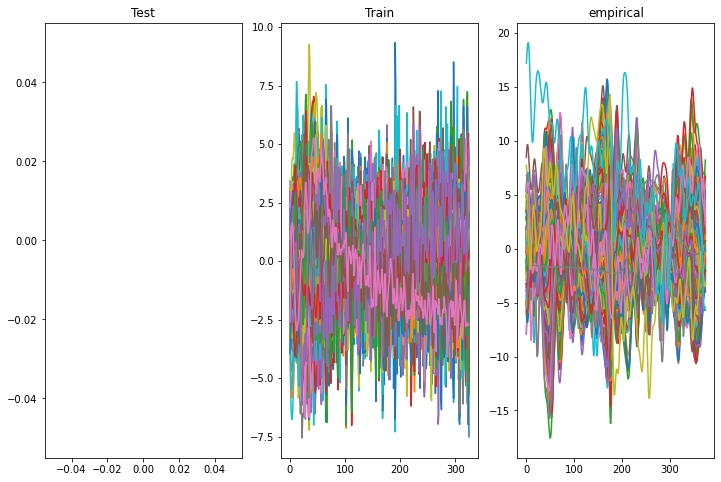

running time is  34588.655210733414 's


In [37]:
start_time = time.time()
node_size = 231
eeg_size = 127
behav_size = 1
stimus_size = 1
batch_size = 326
step_size = 0.0002
input_size = 3
num_epoches = 210*15
tr = 0.002


# Get the WWD model module for forward in a batch. 

for i in range(0,1):# num_epoches):
    print('sub: ', i)
  
    par = ParamsJR(A = [3.25, 0], a= [100, 0.5], B = [22, 0], b = [50, 1], g=[1000, .1], \
                    c1 = [135, 0.2], c2 = [135*0.8, 0.4], c3 = [135*0.25, 0.8], c4 = [135*0.25, 0.8],\
                    std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], y0=[2* np.ones((eeg_size, 1)), 2 * np.ones((eeg_size, 1))],\
                    mu = [.5, 8], k = [5, 1], cy0 = [2, 0], Bm = [40,0.2], Bv =[10,0.5],\
                    W_in = [5 * np.ones((node_size,stimus_size)), .75 * np.ones((node_size,stimus_size))])
                    #w_bb=[-1 * np.ones((200, 200)), 2 * np.ones((200, 200))], \
                    #])
    model = RNNJANSEN(input_size, node_size, batch_size, step_size, eeg_size, behav_size, stimus_size, tr,  sc, dist, lfm/1000, True, par)
    
    
    # fit data(train)
    u = np.zeros((10,eeg.shape[1]-50, num_epoches,1))
    by= np.zeros((eeg.shape[1]-50, num_epoches,1))
    for j in range(num_epoches):
        
        for k in range(10):
            u[k,0:30,j,0] = 250*(-outp[j%eeg.shape[2],0]+outp[:,0].max())
        #u[:,0:,j]= 10000*inp[50:,j%eeg.shape[2]]
        #u[0,:,0:80,j]= 200*inp[j%eeg.shape[2], 0]
        """if inp[j%eeg.shape[2], 0] == 1.0:
            u[:,0:30,j,0]= 400*inp[j%eeg.shape[2], 1]
        else:
            u[:,0:30,j,0]= 400*(1-inp[j%eeg.shape[2], 1])"""

    # call model fit method
    F = Model_fitting(model, eeg[:127,50:376,:], outp[:,1:2], num_epoches)

    output_train = F.train(u)
    #output_test = F.test(u )
    
    """u = np.zeros((node_size,10,800))
    u[22,:,410:415]= 10000
    output_test = F.test(u )

    sc_mod = np.zeros((200,200))
    mask = np.tril_indices(200,-1)


    sc_mod[mask] = F.output_sim.weights[-10:].mean(0)
    sc_mod = sc_mod+sc_mod.T 
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    ax.imshow(sc_mod, cmap = 'bwr')
    plt.show()
    #F.output_sim.save('../data/EEG/sub_'+str(i)+'_fittingresults_rest_diffIn.pkl')
    filename = '../data/EEG/sub_'+str(i)+'_fittingresults_rest.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(F, f)"""    
    
    
    fig, ax = plt.subplots(1,3, figsize=(12,8))
    ax[0].plot(F.output_sim.EEG_test.T)
    ax[0].set_title('Test')
    ax[1].plot(F.output_sim.EEG_train.T)#- F.output_sim.EEG_train.mean(1))
    ax[1].set_title('Train')
    ax[2].plot(eeg[:,:,i].T)
    ax[2].set_title('empirical')
    plt.show()
end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

In [ ]:
filename = 'fittingresults_DMPAD_168_15r.pkl'
with open(filename, 'wb') as f:
    pickle.dump(F, f)

In [ ]:
filename =  'fittingresults_DMPAD_152_15r.pkl'
with open(filename, 'rb') as f:
    F = pickle.load(f)


In [ ]:
F.output_sim.Behav_train.shape

(210, 1)

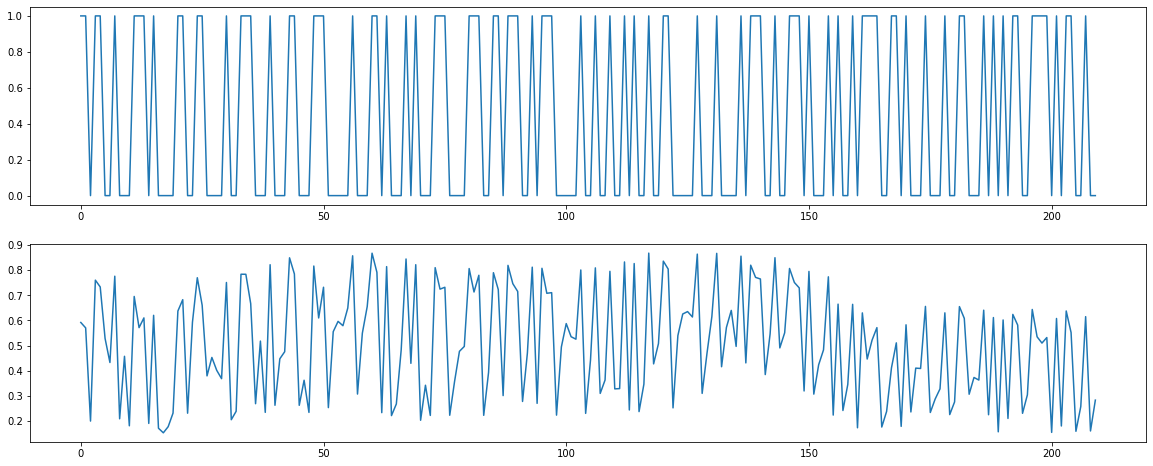

0.8101500051027177


In [38]:
fig, ax=plt.subplots(2,1, figsize=(20,8))
ax[0].plot(outp[:,1])
ax[1].plot(F.output_sim.Behav_train)
plt.show()
print(np.corrcoef(outp[:,1], F.output_sim.Behav_train[:,0])[0,1])

In [ ]:
outp.shape

(210, 3)

IndexError: ignored

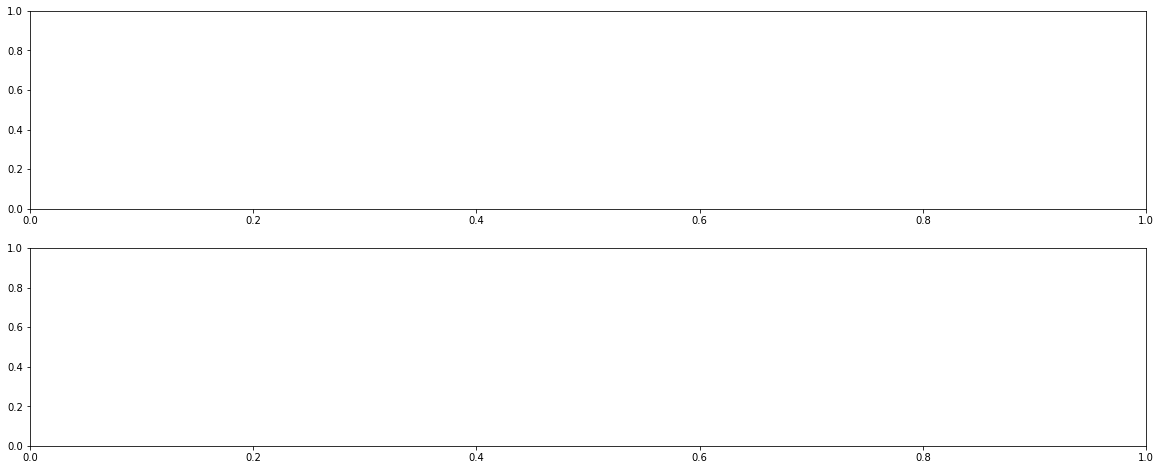

In [39]:
fig, ax=plt.subplots(2,1, figsize=(20,8))
ax[0].plot((outp[:,:,1].T).ravel())
ax[1].plot((F.output_sim.Behav_train[:,1,:]).ravel())
plt.show()
print(np.corrcoef(F.output_sim.Behav_train[:,1,:].ravel(), outp[:,:,1].T.ravel())[0,1])

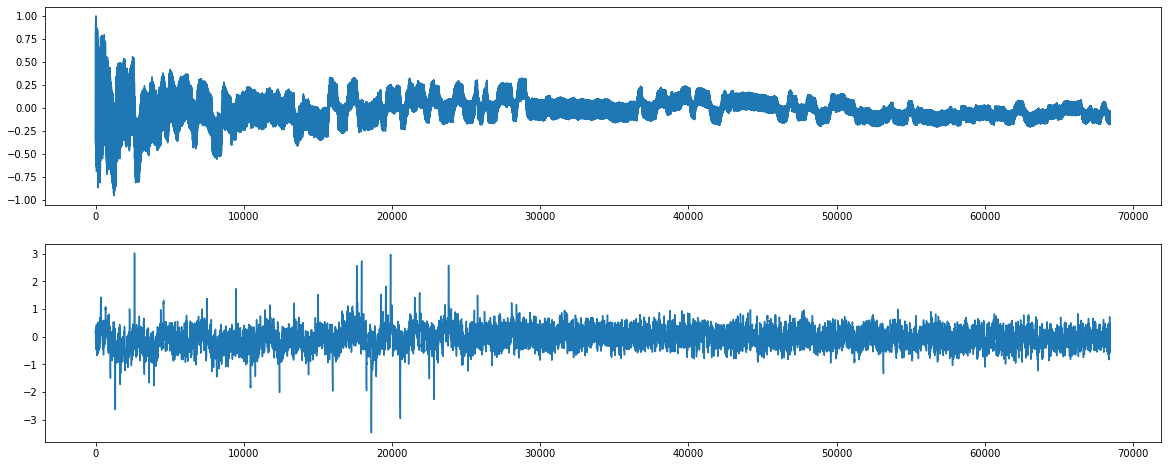

0.19095294724526513


In [ ]:
fig, ax=plt.subplots(2,1, figsize=(20,8))
ax[0].plot((outp_old[:,:,0].T).ravel())
ax[1].plot((F.output_sim.Behav_train[:,0,:]).ravel())
plt.show()
print(np.corrcoef(F.output_sim.Behav_train[:,0,:].ravel(), outp_old[:,:,0].T.ravel())[0,1])

In [ ]:
F.output_sim.Behav_train.shape

(210, 1, 326)

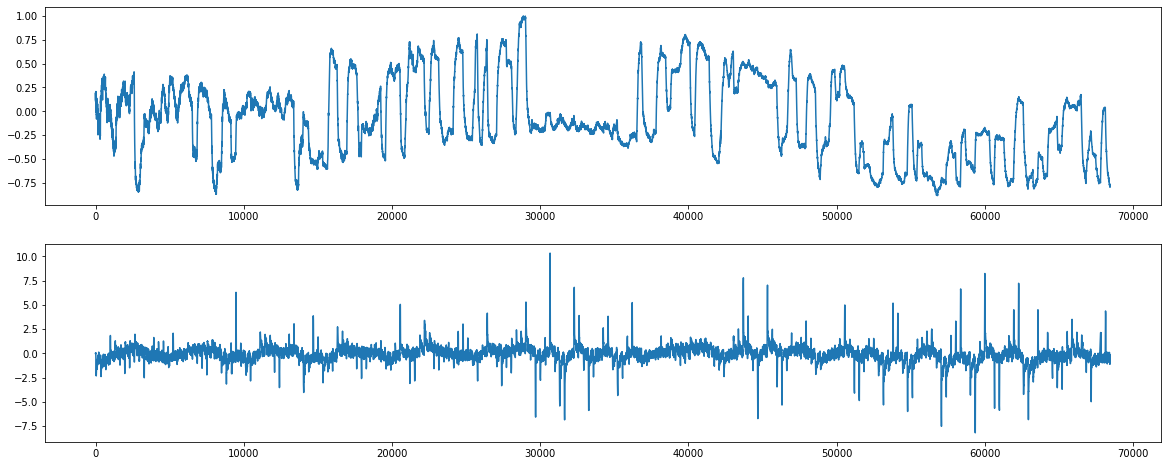

0.18386240501035386


In [ ]:
fig, ax=plt.subplots(2,1, figsize=(20,8))
ax[0].plot((outp[:,:,1].T).ravel())
ax[1].plot((F.output_sim.Behav_train[:,0,:]).ravel())
plt.show()
print(np.corrcoef(F.output_sim.Behav_train[:,1,:].ravel(), outp_old[:,:,2].T.ravel())[0,1])

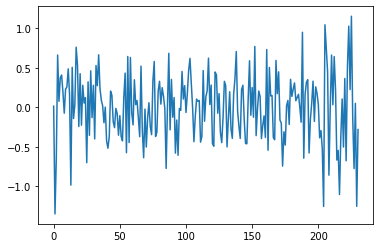

In [ ]:
w=F.model.W_in.detach().numpy()
w= w-w.mean()
plt.plot(w)

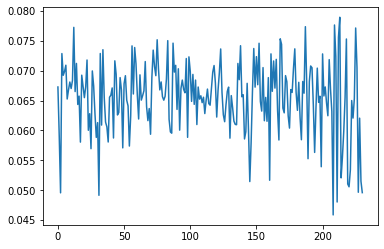

In [ ]:
w=F.model.W_in.detach().numpy()
w= w/np.linalg.norm(w)
plt.plot(w)
#w= w-w.mean()
np.savetxt('pe_weights_152.txt', w)

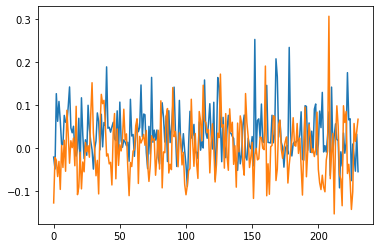

In [ ]:
w=F.model.W_out.detach().numpy()[:,0,:]
w=w/np.linalg.norm(w, axis=0)
plt.plot(w)
np.savetxt('behav_weights_152.txt', w)

In [ ]:
print(np.array(labels)[np.where(np.abs(w[:,1])>0.1)], '\n', np.array(labels)[np.where(np.abs(w[:,0])>.1)])

['7Networks_LH_Vis_1' '7Networks_LH_SomMot_5' '7Networks_LH_SomMot_16'
 '7Networks_LH_DorsAttn_Post_5' '7Networks_LH_DorsAttn_Post_7'
 '7Networks_LH_DorsAttn_Post_8' '7Networks_LH_DorsAttn_Post_9'
 '7Networks_LH_Limbic_TempPole_2' '7Networks_LH_Default_Temp_9'
 '7Networks_LH_Default_PFC_9' '7Networks_RH_Vis_1' '7Networks_RH_Vis_5'
 '7Networks_RH_Vis_14' '7Networks_RH_SomMot_12'
 '7Networks_RH_DorsAttn_FEF_2' '7Networks_RH_SalVentAttn_FrOper_1'
 '7Networks_RH_Limbic_OFC_3' '7Networks_RH_Limbic_TempPole_1'
 '7Networks_RH_Limbic_TempPole_3' '7Networks_RH_Default_Temp_5'
 'LH_Cont_Par_Buckner' 'RH_SomMot_Buckner' 'RH_Cont_Par_Buckner'
 'LH_Amygdala' '7Networks_2' '7Networks_3'] 
 ['7Networks_LH_Vis_3' '7Networks_LH_Vis_5' '7Networks_LH_Vis_13'
 '7Networks_LH_SomMot_8' '7Networks_LH_DorsAttn_FEF_1'
 '7Networks_LH_SalVentAttn_PFCl_1' '7Networks_LH_Limbic_TempPole_3'
 '7Networks_LH_Cont_PFCl_3' '7Networks_LH_Default_Temp_2'
 '7Networks_LH_Default_PFC_1' '7Networks_LH_Default_PFC_10'
 '7Networ

In [ ]:
w=F.model.W_out.detach().numpy()[:,1,:]

plt.plot(w)

NameError: ignored

In [ ]:
print(np.array(labels)[np.where(np.abs(w[:,0])>.07)])

['7Networks_LH_Vis_4' '7Networks_LH_Vis_6' '7Networks_LH_Vis_7'
 '7Networks_LH_Vis_12' '7Networks_LH_SomMot_1' '7Networks_LH_SomMot_4'
 '7Networks_LH_SomMot_5' '7Networks_LH_SomMot_7' '7Networks_LH_SomMot_15'
 '7Networks_LH_DorsAttn_Post_3' '7Networks_LH_DorsAttn_Post_5'
 '7Networks_LH_Limbic_OFC_1' '7Networks_LH_Limbic_TempPole_1'
 '7Networks_LH_Limbic_TempPole_3' '7Networks_LH_Cont_PFCl_3'
 '7Networks_LH_Default_Temp_4' '7Networks_LH_Default_PFC_6'
 '7Networks_LH_Default_PCC_3' '7Networks_RH_Vis_3' '7Networks_RH_Vis_4'
 '7Networks_RH_Vis_14' '7Networks_RH_SomMot_3' '7Networks_RH_SomMot_8'
 '7Networks_RH_SomMot_9' '7Networks_RH_DorsAttn_Post_4'
 '7Networks_RH_DorsAttn_Post_5' '7Networks_RH_SalVentAttn_TempOccPar_2'
 '7Networks_RH_SalVentAttn_FrOper_2' '7Networks_RH_Limbic_TempPole_1'
 '7Networks_RH_Limbic_TempPole_3' '7Networks_RH_Cont_PFCv_1'
 '7Networks_RH_Cont_PFCl_2' '7Networks_RH_Default_Temp_5'
 'LH_Cont_Par_Buckner' 'LH_Default_Buckner' 'RH_Vis_Buckner'
 'RH_SalVentAttn_Buckner

In [ ]:
print(np.array(labels)[np.where(np.abs(w[:,0])>.5)], '\n', np.array(labels)[np.where(np.abs(w[:,0])>.5)])

['7Networks_LH_Vis_7' '7Networks_LH_DorsAttn_Post_1'
 '7Networks_LH_DorsAttn_FEF_1' '7Networks_LH_Limbic_TempPole_2'
 '7Networks_LH_Default_PFC_11' '7Networks_RH_Vis_4'
 '7Networks_RH_SomMot_18' '7Networks_RH_DorsAttn_Post_10'
 '7Networks_RH_Limbic_TempPole_3' '7Networks_RH_Cont_PFCv_1'
 'LH_Vis_Buckner' 'LH_Cont_Par_Buckner' 'RH_Vis_Buckner' 'LH_Putamen'
 'LH_Pallidum' 'LH_Amygdala' '7Networks_1' '7Networks_3' '7Networks_5'] 
 ['7Networks_LH_Vis_7' '7Networks_LH_DorsAttn_Post_1'
 '7Networks_LH_DorsAttn_FEF_1' '7Networks_LH_Limbic_TempPole_2'
 '7Networks_LH_Default_PFC_11' '7Networks_RH_Vis_4'
 '7Networks_RH_SomMot_18' '7Networks_RH_DorsAttn_Post_10'
 '7Networks_RH_Limbic_TempPole_3' '7Networks_RH_Cont_PFCv_1'
 'LH_Vis_Buckner' 'LH_Cont_Par_Buckner' 'RH_Vis_Buckner' 'LH_Putamen'
 'LH_Pallidum' 'LH_Amygdala' '7Networks_1' '7Networks_3' '7Networks_5']


In [ ]:
print(np.array(labels)[np.where(np.abs(w[:,0])>1.)], '\n', np.array(labels)[np.where(np.abs(w[:,0])>1.)])

['7Networks_LH_Vis_2' '7Networks_LH_Vis_7' '7Networks_LH_Limbic_OFC_2'
 '7Networks_RH_Default_Temp_4' 'RH_Vis_Buckner' 'RH_SomMot_Buckner'
 'LH_Hippocampus' 'RH_Amygdala' '7Networks_4'] 
 ['7Networks_LH_Vis_2' '7Networks_LH_Vis_7' '7Networks_LH_Limbic_OFC_2'
 '7Networks_RH_Default_Temp_4' 'RH_Vis_Buckner' 'RH_SomMot_Buckner'
 'LH_Hippocampus' 'RH_Amygdala' '7Networks_4']


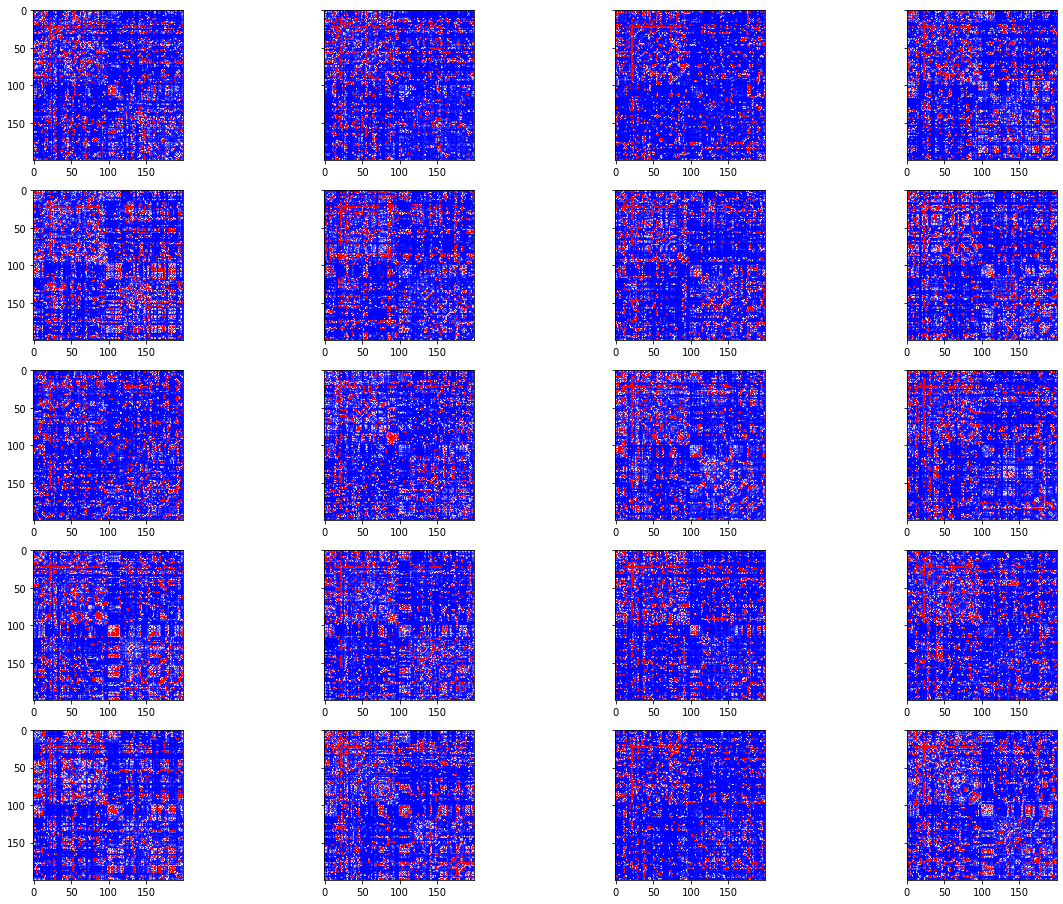

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(20, 16), sharey=True)
for i in range(20):
    file_name = '../data/EEG/sub_'+str(i)+'_fittingresults_long_test1.pkl'
    with open(file_name, 'rb') as f:
        out = pickle.load(f)
    sc_mod = np.zeros((200,200))
    mask = np.tril_indices(200,-1)
    sc_mod[mask] =out.weights[-1,:]
    sc_mod = sc_mod+sc_mod.T
    ax[i//4,i%4].imshow(sc_mod, cmap = 'bwr',vmax=sc_mod.mean()+2*sc_mod.var())
    #sns.heatmap(sc_mod, vmax=sc_mod.mean(), square=True, ax=ax[i//4,i%4])

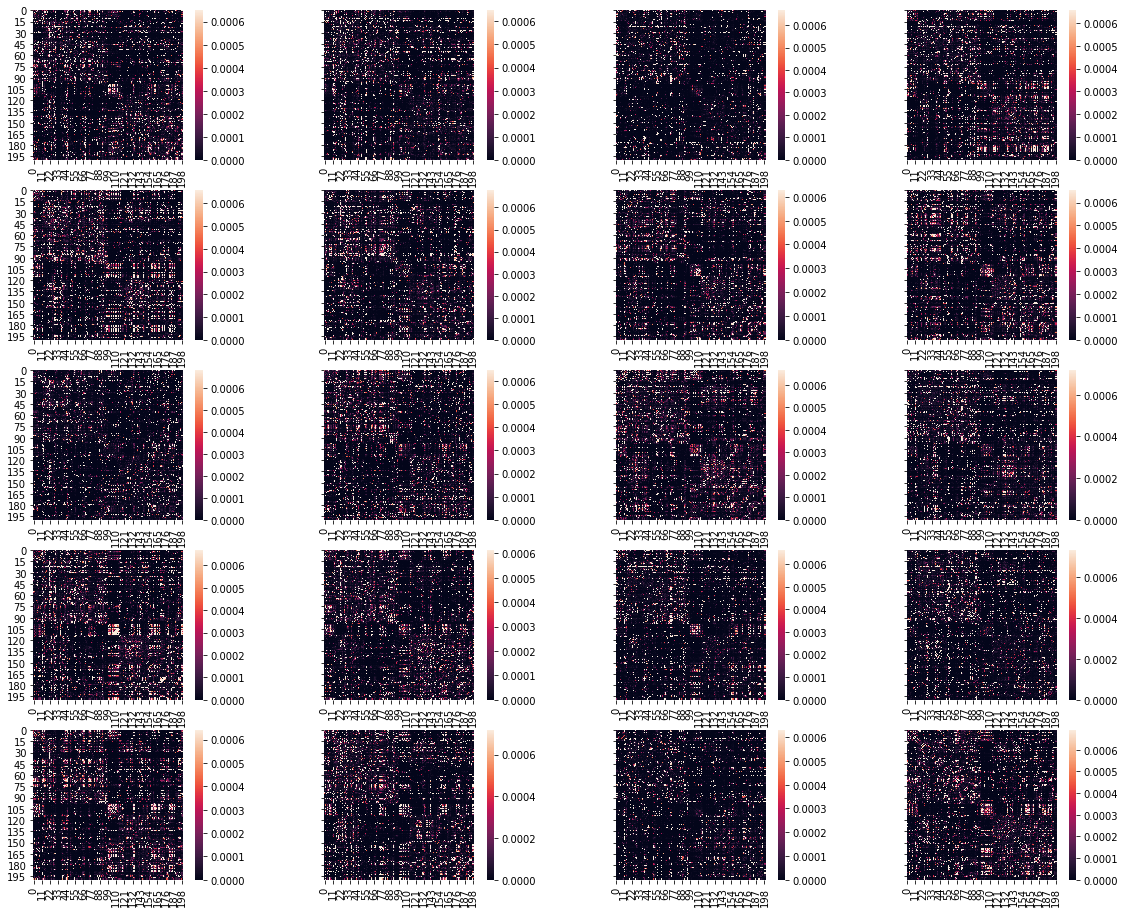

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(20, 16), sharey=True)
for i in range(20):
    file_name = '../data/EEG/sub_'+str(i)+'_fittingresults_long_test1.pkl'
    with open(file_name, 'rb') as f:
        out = pickle.load(f)
    sc_mod = np.zeros((200,200))
    mask = np.tril_indices(200,-1)
    sc_mod[mask] =out.weights[-1,:]
    sc_mod = sc_mod+sc_mod.T
    #ax[i//4,i%4].imshow(sc_mod, cmap = 'bwr',vmax=sc_mod.mean())
    sns.heatmap(sc_mod, vmax=sc_mod.mean(), square=True, ax=ax[i//4,i%4])

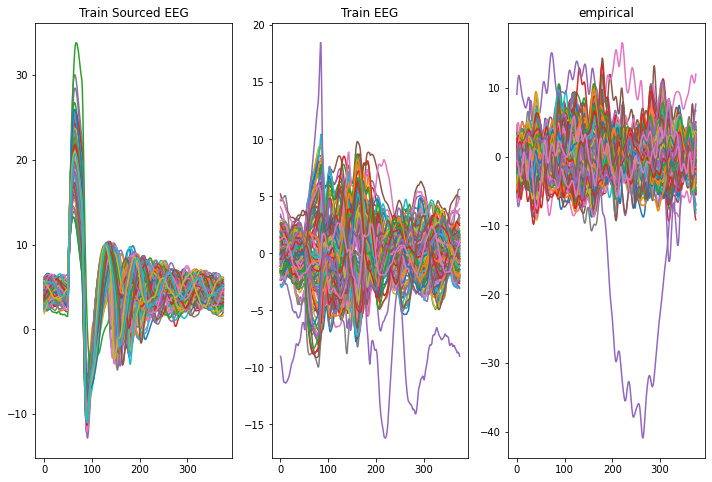

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,8))
ax[0].plot((F.output_sim.E_train-F.output_sim.I_train).T)
ax[0].set_title('Train Sourced EEG')
ax[1].plot(F.output_sim.EEG_train.T)#- F.output_sim.EEG_train.mean(1))
ax[1].set_title('Train EEG')
ax[2].plot(eeg_test[:,:,-1].T)
ax[2].set_title('empirical')
plt.show()

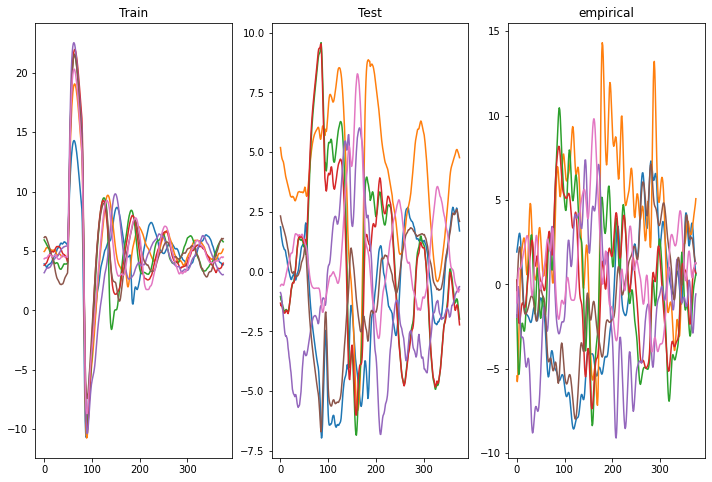

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,8))
ax[0].plot((F.output_sim.E_train-F.output_sim.I_train).T[:,rois])
ax[0].set_title('Train')
ax[1].plot(F.output_sim.EEG_train.T[:,rois])#-F.output_sim.EEG_train[rois,:].mean(1))
ax[1].set_title('Test')
ax[2].plot(eeg_test[:,:,-1].T[:,rois])
ax[2].set_title('empirical')
plt.show()

In [ ]:
rois=np.arange(127)[np.diag(cosine_similarity(F.output_sim.EEG_test, eeg[:127,:,9])) > 0.55]

In [ ]:
rois

In [ ]:
np.diag(cosine_similarity(F.output_sim.EEG_test, eeg[:127,:,9])).mean()

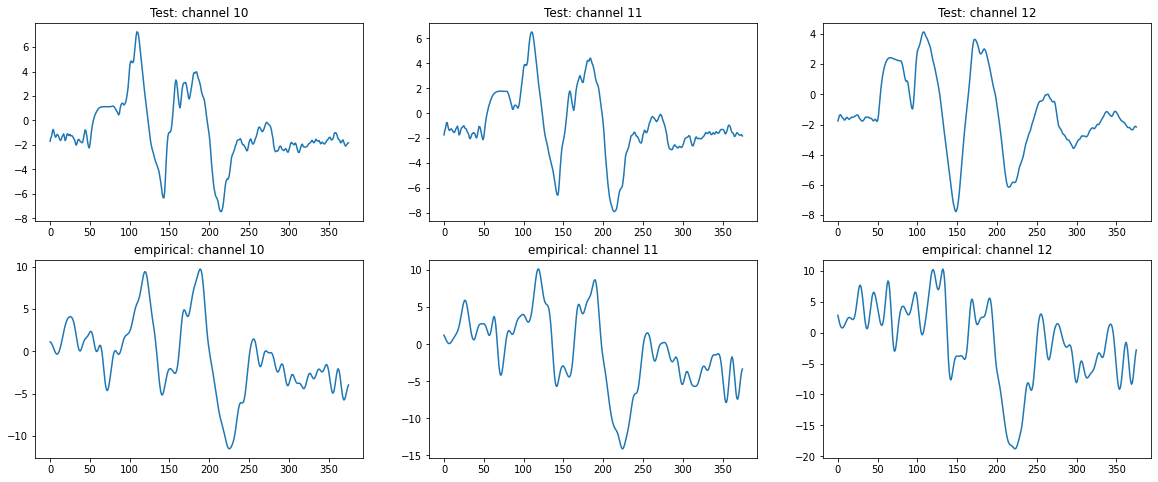

In [ ]:
#rois=np.arange(127)[np.diag(cosine_similarity(F.output_sim.EEG_test, eeg[:,:,5])) > 0.6]
fig, ax = plt.subplots(2,3, figsize=(20,8))
for i in range(3):
    
    ax[0, i].plot(F.output_sim.EEG_test.T[:,rois[0+i]])#-F.output_sim.EEG_train[rois,:].mean(1))
    ax[0,i].set_title('Test: channel '+ str(rois[0+i]))
    ax[1,i].plot(eeg[:127,:,9].T[:,rois[i]])
    ax[1,i].set_title('empirical: channel '+ str(rois[0+i]))
plt.show()

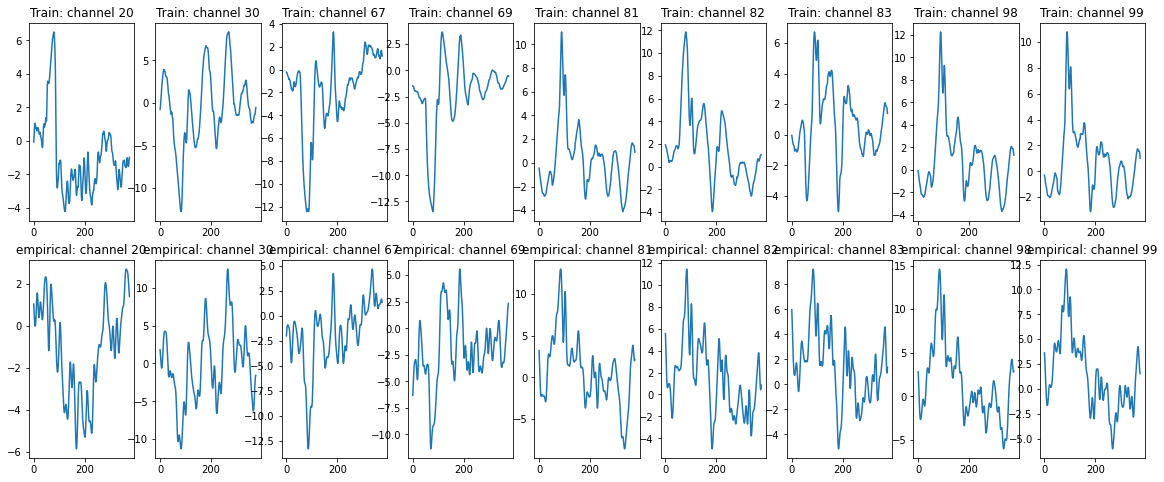

In [ ]:
fig, ax = plt.subplots(2,9, figsize=(20,8))
for i in range(9,18):
    
    ax[0, i-9].plot(F.output_sim.EEG_train.T[:,rois[i]])#-F.output_sim.EEG_train[rois,:].mean(1))
    ax[0,i-9].set_title('Train: channel '+ str(rois[i]))
    ax[1,i-9].plot(eeg_test[:,:,-1].T[:,rois[i]])
    ax[1,i-9].set_title('empirical: channel '+ str(rois[i]))
plt.show()

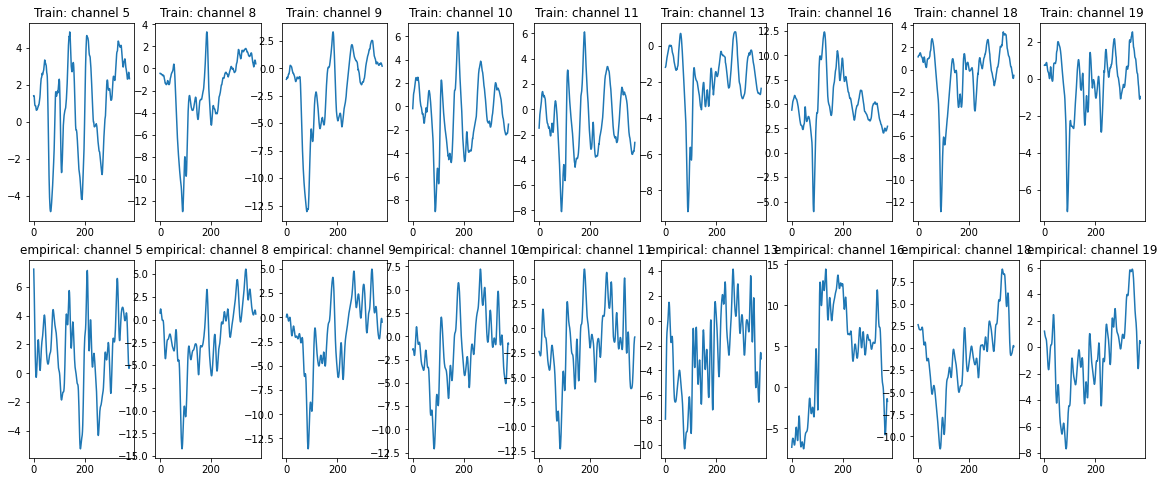

In [ ]:
fig, ax = plt.subplots(2,9, figsize=(20,8))
for i in range(9):
    
    ax[0, i].plot(F.output_sim.EEG_train.T[:,rois[i]])#-F.output_sim.EEG_train[rois,:].mean(1))
    ax[0,i].set_title('Train: channel '+ str(rois[i]))
    ax[1,i].plot(eeg_test[:,:,-1].T[:,rois[i]])
    ax[1,i].set_title('empirical: channel '+ str(rois[i]))
plt.show()

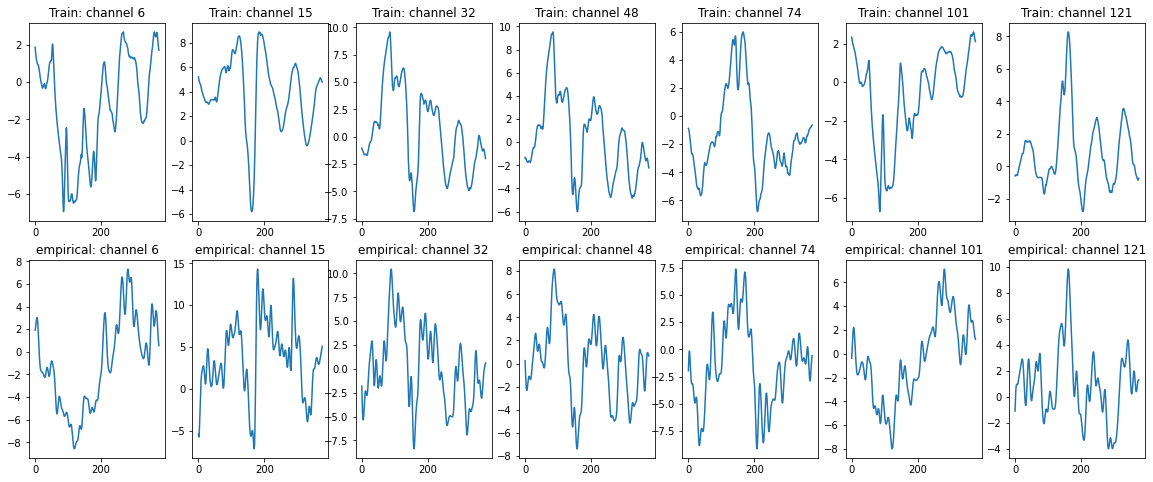

In [ ]:
fig, ax = plt.subplots(2,7, figsize=(20,8))
for i in range(7):
    
    ax[0, i].plot(F.output_sim.EEG_train.T[:,rois[i]])#-F.output_sim.EEG_train[rois,:].mean(1))
    ax[0,i].set_title('Train: channel '+ str(rois[i]))
    ax[1,i].plot(eeg_test[:,:,-1].T[:,rois[i]])
    ax[1,i].set_title('empirical: channel '+ str(rois[i]))
plt.show()

In [ ]:
inp[:10]

array([[1.  , 0.35],
       [1.  , 0.55],
       [0.  , 0.35],
       [1.  , 0.75],
       [1.  , 0.65],
       [1.  , 0.45],
       [0.  , 0.35],
       [1.  , 0.45],
       [0.  , 0.25],
       [1.  , 0.25]])

In [ ]:
a =1
instance(a)

NameError: ignored

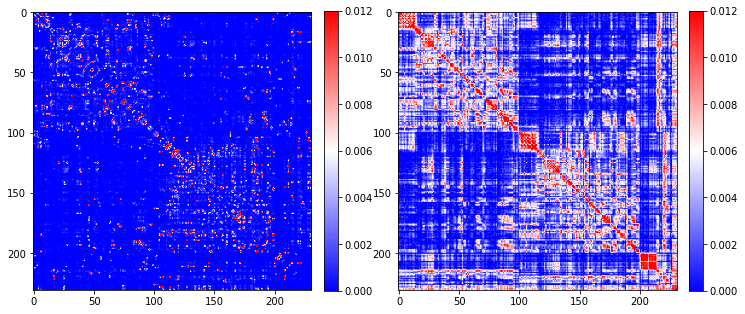

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,8))

sc_mod = np.zeros((231,231))
mask = np.tril_indices(231,-1)
sc_mod[mask] =F.output_sim.weights[-20:,:].mean(0)
sc_mod = sc_mod+sc_mod.T
im =ax[0].imshow(sc_mod, cmap = 'bwr', vmax=0.012)#,vmax=sc_mod.mean()+2*sc_mod.var())
fig.colorbar(im, ax=ax[0],fraction=0.046, pad=0.04)
im =ax[1].imshow(F.model.sc, cmap = 'bwr', vmax=0.012)#,vmax=sc_mod.mean()+2*sc_mod.var())
fig.colorbar(im, ax=ax[1],fraction=0.046, pad=0.04)

ValueError: ignored

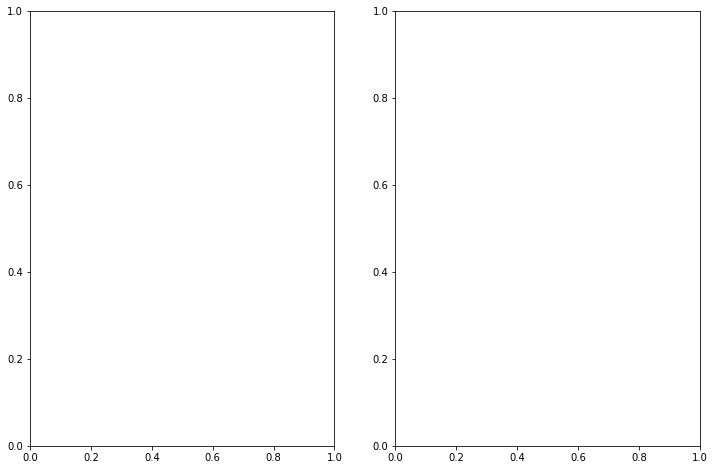

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,8))

sc_mod = np.zeros((200,200))
mask = np.tril_indices(200,-1)
sc_mod[mask] =F.output_sim.weights[-1,:]
sc_mod = sc_mod+sc_mod.T
im =ax[0].imshow(np.log1p(sc_mod), cmap = 'bwr', vmax=0.08)#,vmax=sc_mod.mean()+2*sc_mod.var())
fig.colorbar(im, ax=ax[0],fraction=0.046, pad=0.04)
im1 =ax[1].imshow(sc, cmap = 'bwr')#,vmax=sc_mod.mean()+2*sc_mod.var())
fig.colorbar(im1, ax=ax[1],fraction=0.046, pad=0.04)

In [ ]:
x,y = np.where(sc_mod>0.014)
[(np.array(labels)[x][i], np.array(labels)[y][i]) for i in range(len(x))]

[('7Networks_LH_SomMot_10', '7Networks_LH_DorsAttn_Post_5'),
 ('7Networks_LH_SomMot_10', 'LH_Vis_Buckner'),
 ('7Networks_LH_SomMot_11', '7Networks_LH_DorsAttn_Post_5'),
 ('7Networks_LH_SomMot_16', 'LH_Vis_Buckner'),
 ('7Networks_LH_DorsAttn_Post_5', '7Networks_LH_SomMot_10'),
 ('7Networks_LH_DorsAttn_Post_5', '7Networks_LH_SomMot_11'),
 ('7Networks_LH_Default_Temp_1', '7Networks_LH_Default_PCC_3'),
 ('7Networks_LH_Default_PCC_3', '7Networks_LH_Default_Temp_1'),
 ('7Networks_LH_Default_PCC_3', '7Networks_RH_Cont_PFCl_2'),
 ('7Networks_LH_Default_PCC_3', '7Networks_RH_Cont_PFCmp_1'),
 ('7Networks_RH_Cont_PFCl_2', '7Networks_LH_Default_PCC_3'),
 ('7Networks_RH_Cont_PFCmp_1', '7Networks_LH_Default_PCC_3'),
 ('LH_Vis_Buckner', '7Networks_LH_SomMot_10'),
 ('LH_Vis_Buckner', '7Networks_LH_SomMot_16'),
 ('LH_Vis_Buckner', 'LH_SomMot_Buckner'),
 ('LH_Vis_Buckner', 'LH_DorsAttn_Buckner'),
 ('LH_Vis_Buckner', 'LH_SalVentAttn_Buckner'),
 ('LH_Vis_Buckner', 'LH_Cont_Par_Buckner'),
 ('LH_Vis_Buckner

In [ ]:
np.array(labels))[x]

SyntaxError: ignored